In [38]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime
import re
import numpy as np
from ydata_profiling import ProfileReport
from urllib.parse import urlparse
from transformers import pipeline
import random
import torch
import warnings
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pymorphy3 import MorphAnalyzer
from collections import Counter
import ast

# Постановка задачи

Цель — не просто заполнить пропуски, но и выявить причины их возникновения, эффективно обработать категориальные признаки, устранить выбросы, при необходимости преобразовать данные, подготовив таким образом качественный набор данных для дальнейшей аналитики и машинного обучения.

**Часть 1: «Следствие ведёт детектив»**

- [x]  Возьмите датасет из задания №1 (Модуль 1. Введение в сбор данных)
- [x]  Проанализируйте пропуски: определите их процент и расположение (случайны ли пропуски или есть закономерность?)
- [x]  Сформулируйте гипотезу о возможных причинах появления пропусков.
- [x]  Проанализируйте датасет на выбросы удобным вам методом.

---

**Часть 2: «Выбор подходящего оружия»**

- [x]  Примените несколько разных методов работы с пропусками, выбросами.
- [x]  Приведите данные в единый вид, поработайте над категориальными признаками.
- [x]  Оцените, как каждый из методов повлиял на распределение данных и результаты простого анализа (например, расчёт среднего или простая регрессия).

---

**Часть 3: «Раскрытие дела»**

- [x]  Выберите и обоснуйте самый эффективный метод для вашего набора данных.
- [x]  Сформулируйте краткую рекомендацию по оптимальному подходу к обработке пропущенных значений в вашем датасете.

🏆 **Дополнительные баллы** («Расследование с изюминкой»):

*+3 балла* Предложите собственный метод или комбинацию методов, которые лучше всего подходят именно для вашего случая.

# Чтение данных

In [2]:
data = pd.read_csv('data/real_fake_news_dataset.csv', index_col=0)
data.shape

(3616, 7)

In [3]:
data.head()

url  \
0       https://ria.ru/20250402/smi-2008994289.html   
1  https://ria.ru/20250402/poshliny-2008993829.html   
2     https://ria.ru/20250402/vzryv-2008993522.html   
3     https://ria.ru/20250402/tramp-2008993302.html   
4      https://ria.ru/20250402/bpla-2008993170.html   

                                                                        title  \
0  Глава Пентагона впервые не примет участия во встрече по Украине, пишут СМИ   
1                                 США ввели пошлины на товары из других стран   
2       Несущие конструкции здания в Перевозе после взрыва газа не повреждены   
3                         Трамп раскрыл размер пошлин на товары из ЕС и Китая   
4                          В Краснодарском крае объявили опасность атаки БПЛА   

                                                                                                                                                                                                                                                                                                          full_text  \
0  ВАШИНГТОН, 2 апр – РИА Новости. Министр обороны США Пит Хегсет не примет участия во встрече международной коалиции по оказанию военной поддержки Украине, которая запланирована на 11 апреля в Брюсселе, сообщает издание Defense News со ссылкой на источники среди американских и европейских должностных лиц.   
1                                                                                                                                                                                            ВАШИНГТОН, 2 апр — РИА Новости. Президент США Дональд Трамп объявил о введении новых пошлин на продукцию других стран.   
2                                                                                                   НИЖНИЙ НОВГОРОД, 2 апр - РИА Новости. Несущие конструкции офисного здания в городе Перевоз Нижегородской области, где произошел взрыв газовоздушной смеси, не повреждены, сообщает региональное управление МЧС.   
3                                                                                                                                                           ВАШИНГТОН, 2 апр - РИА Новости. США вводят пошлины в размере 20% на товары из ЕС, 34% - на товары из Китая, заявил в среду президент США Дональд Трамп.   
4                                                                                                                                                                                             МОСКВА, 2 апр - РИА Новости. Опасность атаки БПЛА объявлена в Краснодарском крае, сообщается в приложении МЧС России.   

     date_published views  \
0  23:54 02.04.2025    52   
1  23:53 02.04.2025    60   
2  23:52 02.04.2025   105   
3  23:51 02.04.2025   405   
4  23:50 02.04.2025    64   

                                                                          tags  \
0      ['В мире', 'США', 'Украина', 'Брюссель', 'Пит Хегсет', 'Дональд Трамп']   
1           ['В мире', 'США', 'Тайвань', 'Дональд Трамп', 'Евросоюз', 'Китай']   
2                                                    ['Нижегородская область']   
3                     ['США', 'Китай', 'Тайвань', 'Дональд Трамп', 'Евросоюз']   
4  ['Специальная военная операция на Украине', 'Краснодарский край', 'Россия']   

   target  
0    True  
1    True  
2    True  
3    True  
4    True

## Часть 1: «Следствие ведёт детектив»

In [4]:
# Предварительный просмотр данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3616 entries, 0 to 1061
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             3616 non-null   object
 1   title           2554 non-null   object
 2   full_text       3611 non-null   object
 3   date_published  3613 non-null   object
 4   views           3276 non-null   object
 5   tags            2554 non-null   object
 6   target          3616 non-null   bool  
dtypes: bool(1), object(6)
memory usage: 201.3+ KB


In [5]:
# Анализ пропущенных значений
data.isnull().sum()

url                  0
title             1062
full_text            5
date_published       3
views              340
tags              1062
target               0
dtype: int64

In [6]:
# Процент пропущенных значений
print(data.isnull().sum() / len(data) * 100)

url                0.000000
title             29.369469
full_text          0.138274
date_published     0.082965
views              9.402655
tags              29.369469
target             0.000000
dtype: float64


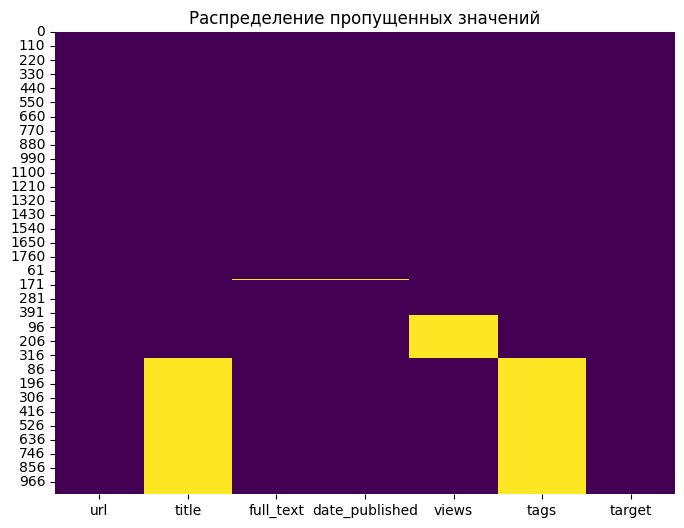

In [7]:
# Визуализация пропущенных значений
plt.figure(figsize=(8, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Распределение пропущенных значений')
plt.show()

In [8]:
# Анализ пропусков в графах title и tags
data[data['title'].isna()].head()

url title  \
0  https://uk.tgstat.com/channel/@spletnicca/18171   NaN   
1     https://uk.tgstat.com/channel/@ZeRada1/23866   NaN   
2   https://tgstat.ru/channel/@boris_rozhin/155972   NaN   
3    https://tgstat.ru/channel/@slavaded1337/70773   NaN   
4        https://tgstat.ru/channel/@grafynia/32626   NaN   

                                                                                                                                                                                                                                                                                                                                                full_text  \
0  Я такой радый. Форева Грейт Брита! Спасибо, Борис! Мы будем благодарны до конца жизни\nПод Курахово погиб Варчук Сергей Юрьевич, который в 2022 на углу Лютеранской и Заньковецкой в Киеве сыграл перед Джонсоном благодарного украинца.\nПророчески получилось. «Благодаря» Джонсону война затянулась на 3 года, а военный так и не смог её пережить.   
1  Я такой радый. Форева Грейт Брита! Спасибо, Борис! Мы будем благодарны до конца жизни\nПод Курахово погиб Варчук Сергей Юрьевич, который в 2022 на углу Лютеранской и Заньковецкой в Киеве сыграл перед Джонсоном благодарного украинца.\nПророчески получилось. «Благодаря» Джонсону война затянулась на 3 года, а военный так и не смог её пережить.   
2                                                                                                                                                                  Российские войска ликвидировали персонажа, который в 2022-году бурно и постановочно радовался визиту Бориса Джонсона в Киев. Так сказать поприветствовал причины своей будущей смерти.   
3                                                                                      Я такой радый. Форева Грейт Брита! Спасибо, Борис! Мы будем благодарны до конца жизни\nПод Курахово погиб Варчук Сергей Юрьевич, который в 2022 на углу Лютеранской и Заньковецкой в Киеве сыграл перед Джонсоном благодарного украинца.\nДядя Слава. Подписаться.   
4                                                                                                                             Под Курахово погиб ВСУшник Сергей Юрьевич Варчук. Он знаменит благодаря видео 2022 года, где изображал «обычного киевлянина, который очень рад встрече с Борисом Джонсоном». Не дождался своего Оскара.\nЗдоровья усопшему.   

  date_published   views tags  target  
0  26 Feb, 21:24  336.7k  NaN   False  
1  27 Feb, 00:16  236.4k  NaN   False  
2  27 Feb, 11:34  205.8k  NaN   False  
3  27 Feb, 10:53  185.4k  NaN   False  
4  26 Feb, 14:07  126.8k  NaN   False

In [9]:
# Анализ пропусков в графе views
data[data['views'].isna()].head()

url  \
0                                                           https://lenta.ru/news/2025/03/01/ocago/   
1                                                           https://lenta.ru/news/2025/03/01/ocago/   
2        https://lenta.ru/news/2025/03/01/zelenskiy-vyskazalsya-o-perepalke-s-trampom-v-belom-dome/   
3                    https://lenta.ru/news/2025/03/01/v-ssha-sochli-skandal-v-belom-dome-lovushkoy/   
4  https://lenta.ru/news/2025/03/01/mask-vyskazalsya-o-novoy-strategii-zelenskogo-vesti-peregovory/   

                                                                 title  \
0  30 лет назад погиб Влад Листьев — самый известный журналист России.   
1  30 лет назад погиб Влад Листьев — самый известный журналист России.   
2                         Зеленский отказался извиниться перед Трампом   
3                 В США сочли скандал в Белом доме ловушкой для Европы   
4        Маск высказался о новой стратегии Зеленского вести переговоры   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          full_text  \
0  С 1 марта в России вступают в силу изменененные правила регистрации автомобилей. Соответствующий закон опубликован на официальном портале правовой информации В частности, теперь нет необходимости предъявлять при регистрации транспортного средства (ТС) полис ОСАГО. При этом, передвижение без него по-прежнему запрещено. Еще одно изменение касается утилизационного сбора: если автомобиль ввезен в Россию по льготному тарифу для физических лиц для личного пользования (сумма сбора составляет от 3,4 до 5,2 тысячи рублей в зависимости от возраста ТС) и продается до истечения годового срока, за него потребуется оплатить коммерческий утильсбор (до 1,5 миллиона рублей), иначе новый собственник не сможет поставить машину на учет. Также с 1 марта можно прекратить регистрацию ТС сразу в день его продажи — раньше, если новый собственник не регистрировал машину на себя, это можно было сделать только по прошествии десяти дней. При этом, автовладельцев лишили возможности прекращать регистрацию автомобиля просто по своему желанию — теперь для этого нужна веская причина, например, продажа. Право прекратить регистрацию в любой момент по заявлению оставили только автодилерам и собственникам, чьи машины были угнаны либо уничтожены. Ранее сообщалось, что в Госдуме предложили законодательно закрепить норму, согласно которой предлагается аннулировать регистрацию транспортных средств за езду на шумном автомобиле.   
1  С 1 марта в России вступают в силу изменененные правила регистрации автомобилей. Соответствующий закон опубликован на официальном портале правовой информации В частности, теперь нет необходимости пре

In [10]:
# Анализ пропусков в графе full_text
data[data['full_text'].isna()].head()

url  \
127      https://ria.ru/20250405/usadby-2006063831.html   
207      https://ria.ru/20250405/usadby-2006063831.html   
327      https://ria.ru/20250405/usadby-2006063831.html   
964           https://tgstat.ru/channel/@apwagner/28142   
1060  https://uk.tgstat.com/channel/@kharkiv_1654/30106   

                                                           title full_text  \
127   Усадьбы поэтов. Самые живописные имения недалеко от Москвы       NaN   
207   Усадьбы поэтов. Самые живописные имения недалеко от Москвы       NaN   
327   Усадьбы поэтов. Самые живописные имения недалеко от Москвы       NaN   
964                                                          NaN       NaN   
1060                                                         NaN       NaN   

         date_published   views  \
127                 NaN   44477   
207                 NaN   44477   
327                 NaN   44477   
964   7 Sep 2024, 12:26  113.1k   
1060  9 Mar 2022, 10:03   62.1k   

                                                                                        tags  \
127   ['Туризм', 'Туризм', 'Усадьба', 'Маршруты - Туризм', 'куда поехать', 'что посмотреть']   
207   ['Туризм', 'Туризм', 'Усадьба', 'Маршруты - Туризм', 'куда поехать', 'что посмотреть']   
327   ['Туризм', 'Туризм', 'Усадьба', 'Маршруты - Туризм', 'куда поехать', 'что посмотреть']   
964                                                                                      NaN   
1060                                                                                     NaN   

      target  
127     True  
207     True  
327     True  
964    False  
1060   False

In [11]:
# Анализ пропусков в графе date_published
data[data['date_published'].isna()].head()

url  \
127  https://ria.ru/20250405/usadby-2006063831.html   
207  https://ria.ru/20250405/usadby-2006063831.html   
327  https://ria.ru/20250405/usadby-2006063831.html   

                                                          title full_text  \
127  Усадьбы поэтов. Самые живописные имения недалеко от Москвы       NaN   
207  Усадьбы поэтов. Самые живописные имения недалеко от Москвы       NaN   
327  Усадьбы поэтов. Самые живописные имения недалеко от Москвы       NaN   

    date_published  views  \
127            NaN  44477   
207            NaN  44477   
327            NaN  44477   

                                                                                       tags  \
127  ['Туризм', 'Туризм', 'Усадьба', 'Маршруты - Туризм', 'куда поехать', 'что посмотреть']   
207  ['Туризм', 'Туризм', 'Усадьба', 'Маршруты - Туризм', 'куда поехать', 'что посмотреть']   
327  ['Туризм', 'Туризм', 'Усадьба', 'Маршруты - Туризм', 'куда поехать', 'что посмотреть']   

     target  
127    True  
207    True  
327    True

In [12]:
# Анализ данных с помощью библиотеки ydata_profiling
profile = ProfileReport(data, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 16.97it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Общее количество записей в датасете:**

- 3616

**Результаты анализа пропусков:**

- `title`: Пропущено около `29.36%` значений.
- `full_text`: Пропущено около `0.14%` значений (очень мало).
- `date_published`: Пропущено около `0.08%` значений (крайне мало).
- `views`: Пропущено около `9.40%` значений.
- `tags`: Пропущено около `29.36%` значений.


**Закономерность пропусков:**

- Пропуски в графах `title` и `tags` совпадают по количеству (`1062`) и расположению. Источник новостей — `Telegram`.
- Пропуски в графе `views` наблюдаются в источнике новостей — `Lenta.ru`.
- Пропуски в графах `full_text` и `date_published` минимальны, причем фильтрация датасета по этим пропускам показала, что в нем есть дубликаты записей, которые нужно почистить.


**Гипотезы о возможных причинах появления пропусков:**

- Пропуски в графак `title`, `tags` и `views` закономерны, так как на ресурсах `Telegram` отсутствуют элементы в верстке с заголовком и тегами, ровно как и на портале `Lenta.ru` отсутствует функционал подсчета просмотра новостей.
- Пропуски в графах `full_text` и `date_published` скорее всего связаны с технической ошибкой парсинга и являются выбросами, их количество минимально. Относительно текста возможен и такой вариант, что вместо текста было размещено только видео или изображение, и спарсить ничего не удалось.

### Анализ датасета на выбросы

In [13]:
# Добавление числовых признаков в датасет
# Подсчет длины текста
def get_text_len(data):
    if pd.isna(data):
        return 0
    return len(data)

data['title_len'] = data.title.apply(get_text_len)
data['full_text_len'] = data.full_text.apply(get_text_len)

In [14]:
# Преобразование 'views' в числовой формат
def preprocess_views(data):
    if pd.isna(data):
        return 0
    elif 'k' in data:
        data = pd.to_numeric(data[:-1]) * 1000
    elif 'm' in data:
        data = pd.to_numeric(data[:-1]) * 1000000
    else:
        data = pd.to_numeric(data)
    return data

data['views_clean'] = data.views.apply(preprocess_views) 

In [15]:
# Удаление дублирующих новостей
data.drop_duplicates(subset='full_text', keep='first', inplace=True)
data.shape

(1754, 10)

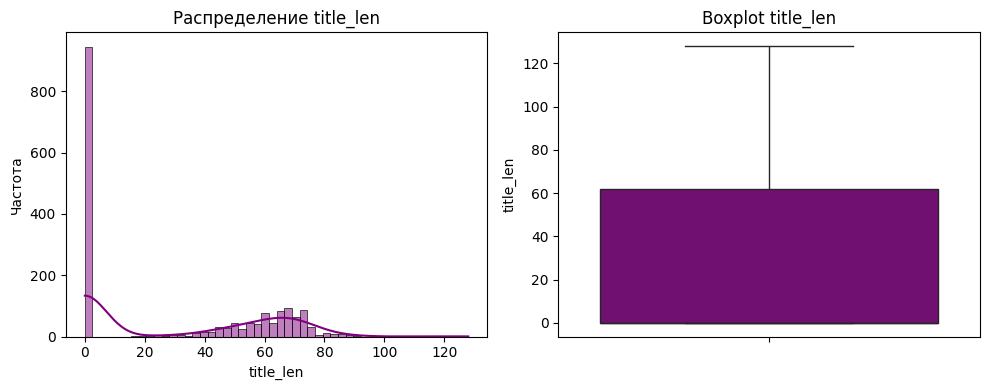


Описательная статистика для столбца 'title_len':
count    1754.000000
mean       28.588369
std        32.228707
min         0.000000
25%         0.000000
50%         0.000000
75%        62.000000
max       128.000000
Name: title_len, dtype: float64


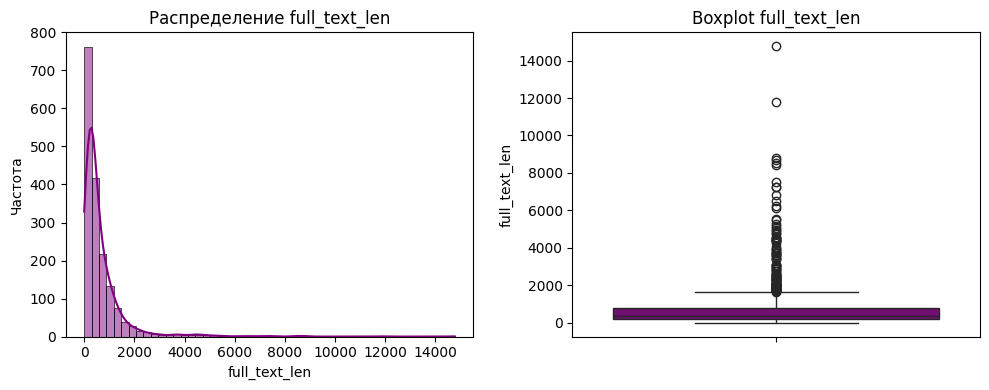


Описательная статистика для столбца 'full_text_len':
count     1754.000000
mean       664.039909
std       1001.741921
min          0.000000
25%        201.000000
50%        341.000000
75%        770.000000
max      14768.000000
Name: full_text_len, dtype: float64


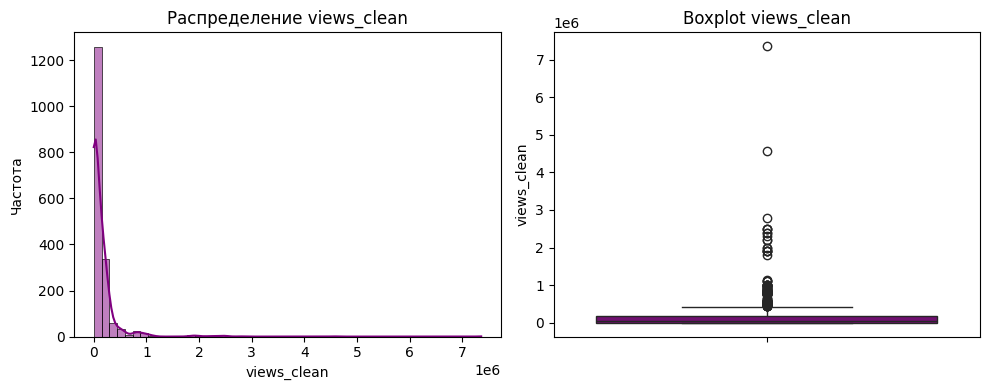


Описательная статистика для столбца 'views_clean':
count    1.754000e+03
mean     1.366937e+05
std      3.323960e+05
min      0.000000e+00
25%      5.030000e+02
50%      4.530000e+04
75%      1.759250e+05
max      7.356376e+06
Name: views_clean, dtype: float64


In [16]:
# График распределений числовых признаков и их выбросов
def visualize_views_distribution(df, column_name):
    
    views_data = data[column_name]
    plt.figure(figsize=(10, 4))

    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(views_data, kde=True, bins=50, color='purple')
    plt.title(f'Распределение {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Частота')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=views_data, color='purple')
    plt.title(f'Boxplot {column_name}')
    plt.ylabel(column_name)

    plt.tight_layout()
    plt.show()

    # Вывод описательной статистики
    print(f"\nОписательная статистика для столбца '{column_name}':")
    print(views_data.describe())


visualize_views_distribution(data, 'title_len')
visualize_views_distribution(data, 'full_text_len')
visualize_views_distribution(data, 'views_clean')

In [17]:
# Определение выбросов с помощью межквартильного размаха (IQR)
def iqr_metric(column_name):
    Q1_views = data[column_name].quantile(0.25)
    Q3_views = data[column_name].quantile(0.75)
    IQR_views = Q3_views - Q1_views
    lower_bound = Q1_views - 1.5 * IQR_views
    upper_bound = Q3_views + 1.5 * IQR_views
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    print(f"Количество выбросов в '{column_name}' (IQR): {len(outliers)}")
    return outliers

outliers_title = iqr_metric('title_len')
outliers_full_text = iqr_metric('full_text_len')
outliers_view = iqr_metric('views_clean')

Количество выбросов в 'title_len' (IQR): 0
Количество выбросов в 'full_text_len' (IQR): 124
Количество выбросов в 'views_clean' (IQR): 102


Графа **'title_len'**:
- Распределение длины заголовков является бимодальным, с большим количеством отсутствующих заголовков (длина 0) и значительной группой заголовков средней длины (50-70 символов).

Графа **'full_text_len'**:
- Сильная скошенность вправо
- Пик в районе нуля (преобладание коротких новостей (примерно до 500 символов)
- Редкие высокие значения (свыше 14000 символов)

Графа **'views'**:
- Сильная скошенность вправо
- Пик в районе нуля (большая доля текстов не имеет значений по просмотрам)
- Редкие высокие значения (вплоть до 7 миллионов)

Интересно также посмотреть распределения и выбросы в разрезе целевой переменной и по источнику новостей.

In [18]:
# Выделение источника новостей в графу 'source'
def extract_source(url):
    if isinstance(url, str):
        parsed_url = urlparse(url)
        return parsed_url.netloc
    return None

def create_source_column(df, url_column='url', new_column='source'):
    df[new_column] = df[url_column].apply(extract_source)
    return df

data = create_source_column(data)
print(data.source.value_counts())

source
tgstat.ru        863
ria.ru           503
lenta.ru         306
uk.tgstat.com     70
tgstat.com         9
uz.tgstat.com      2
by.tgstat.com      1
Name: count, dtype: int64


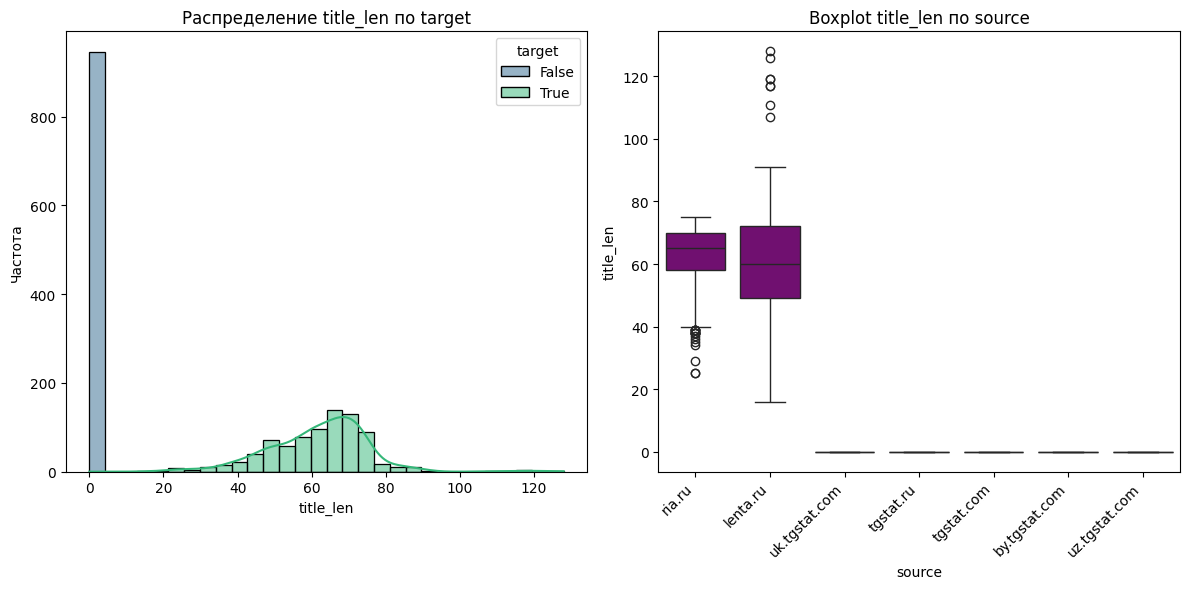

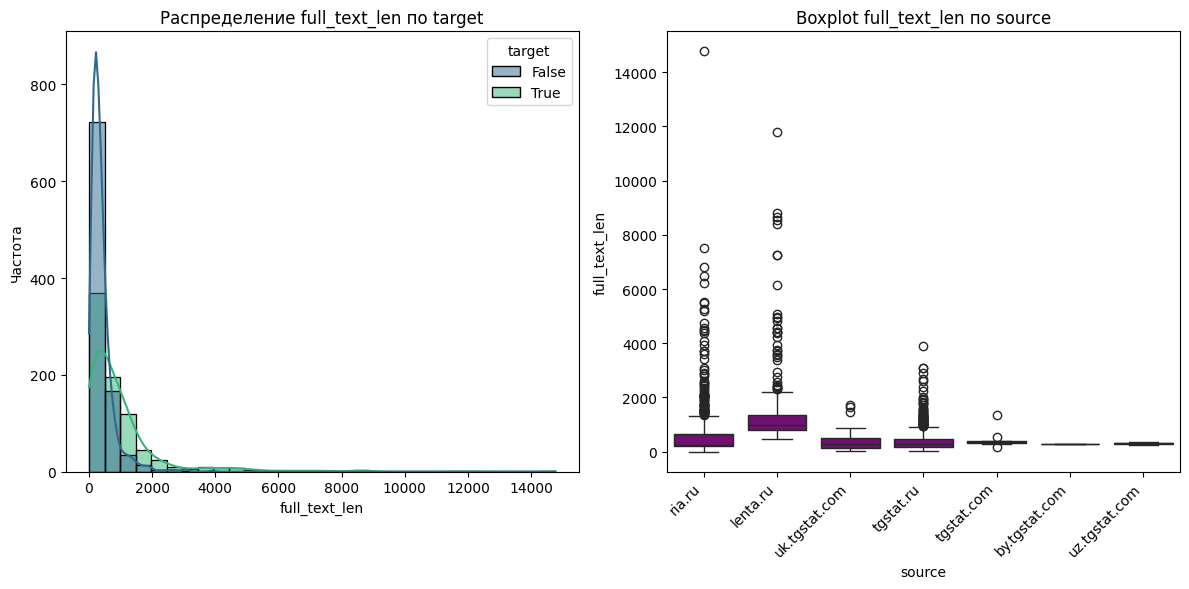

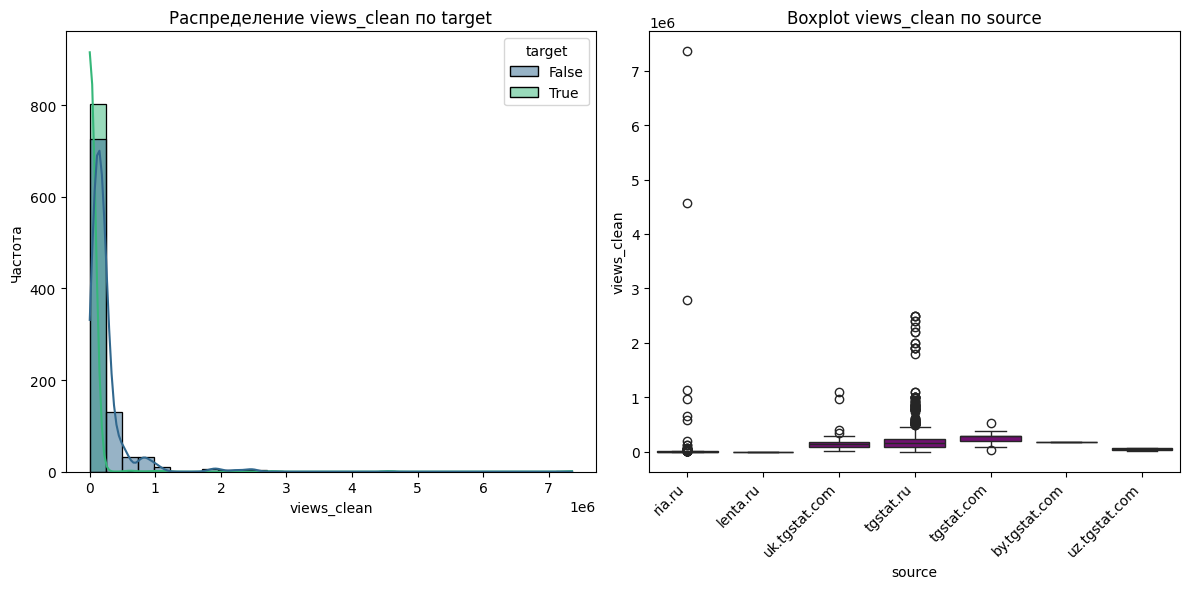

In [19]:
# График распределений числовых признаков по целевой переменной и источнику
def visualize_distribution(df, column_name, category_column, target_column):
    views_data = df[column_name]
    category_data = df[category_column]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

    # Гистограмма по целевой переменной
    sns.histplot(ax=axes[0], data=df, x=column_name, hue=target_column, kde=True, bins=30, palette='viridis')
    axes[0].set_title(f'Распределение {column_name} по {target_column}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Частота')

    # Boxplot по источнику
    sns.boxplot(ax=axes[1], x=category_data, y=views_data, color='purple')
    axes[1].set_title(f'Boxplot {column_name} по {category_column}')
    axes[1].set_xlabel(category_column)
    axes[1].set_ylabel(column_name)
    axes[1].set_xticks(range(len(data[category_column].unique())))
    axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45, ha='right',)
    plt.subplots_adjust(bottom=0.4) 

    plt.tight_layout()
    plt.show()


visualize_distribution(data, 'title_len', 'source', 'target')
visualize_distribution(data, 'full_text_len', 'source', 'target')
visualize_distribution(data, 'views_clean', 'source', 'target')

**Влияние источника:** Источник является важным фактором, влияющим на длину заголовка, длину текста и количество просмотров. 

**Выбросы:** Во всех трех признаках наблюдаются выбросы, особенно в количестве просмотров и длине полного текста.

Снова видно, что у `Telegram` нет заголовков, у `Lenta.ru` есть несколько длинных заголовков.

Длинные новости очевидно у `РИА Новости` и `Lenta.ru`, при этом у `РИА Новости` есть статья в более чем в `14000` символов.

В среднем по просмотрам лидирует `Telegram`, но у `РИА Новости` есть выбросы в `4 млн.` и `7 млн.` просмотров.

## Часть 2: «Выбор подходящего оружия»

**Работа с пропусками и выбросами**

1.  **Удаление строк с пропусками в графах `full_text` и `date_published`**

Удалим строку `127`, так как в ней нет полного текста новости, который нам важен.

После удаления дубликатов пропусков с `date_published` не осталось.

2.  **Заполнение пропусков в графе `title` + обработка выбросов**

Для графы `title` можно попробовать заполнить пропуски
- отрезав первое предложение от основного текста
- сгенерировав нейросетью из основного текста новости

Можно оставить заголовки без обработки, так как, например, для задачи классификации реальных и фейковых новостей нужен полный текст новости, и обычно заголовок с ним сливают в единый текст. Поэтому отсутствие заголовка может быть не критичным моментом в обучении.  

Выбросы обработаем, отрезав длину строки.

3.  **Заполнение пропусков в графе `views`**

Для графы `views` можно попробовать заполнить пропуски
- медианным значением
- средним значением (без учета сильных выбросов)

В качестве гипотезы можно рассмотреть вариант обучения `LogisticRegression` или `CatBoost` для прогнозирования просмотров на основе полного текста.
Большое количество просмотров следует удалить, чтобы не влияло на все распределение в целом, например более 1 млн. просмотров, это могут быть какие-то вирусные новости или даже накрутка.

4.  **Заполнение пропусков в графе `tags`**

Для графы `tags` можно попробовать заполнить пропуски
- сделав тематическое моделирование
- создав бинарные признаки, указывающие на наличие определенных популярных тегов

5.  **Работа с выбросами в графе `full_text`**

Для графы `full_text` можно скорректировать выбросы
- обрезав длинные тексты по порогу
- удалив строки

In [20]:
# Удаление строки с пропуском в графе full_text
data = data.drop(index=127)

**Создание заголовка путем отрезания кусочка от основного текста + удаление выбросов**

In [21]:
# Заполнение пустых строк заголовков с помощью 'Без заголовка'
data['title'] = data.title.fillna('Без заголовка')

In [22]:
# Формирование заголовков из полного текста статьи + обрезка слишком длинных заголовков
def cut_text_for_title(data):    
    if data.title == 'Без заголовка':
        try:
            title = re.search(r'^.*?[.!?]', data.full_text).group().strip()            
            if len(title) > 150: # Отрезаем от заголовка свыше 150 символов            
                return title[:150]
            return title
        except AttributeError:     
            rand = random.randint(60, 90)
            return data.full_text[:rand] # Большинство заголовков длинной 60-90 символов        
    else:
        if len(data.title) > 150: # Отрезаем от заголовка свыше 150 символов 
            return data.title[:150]
        else:
            return data.title

data['title_cut_ft'] = data.apply(cut_text_for_title, axis=1)

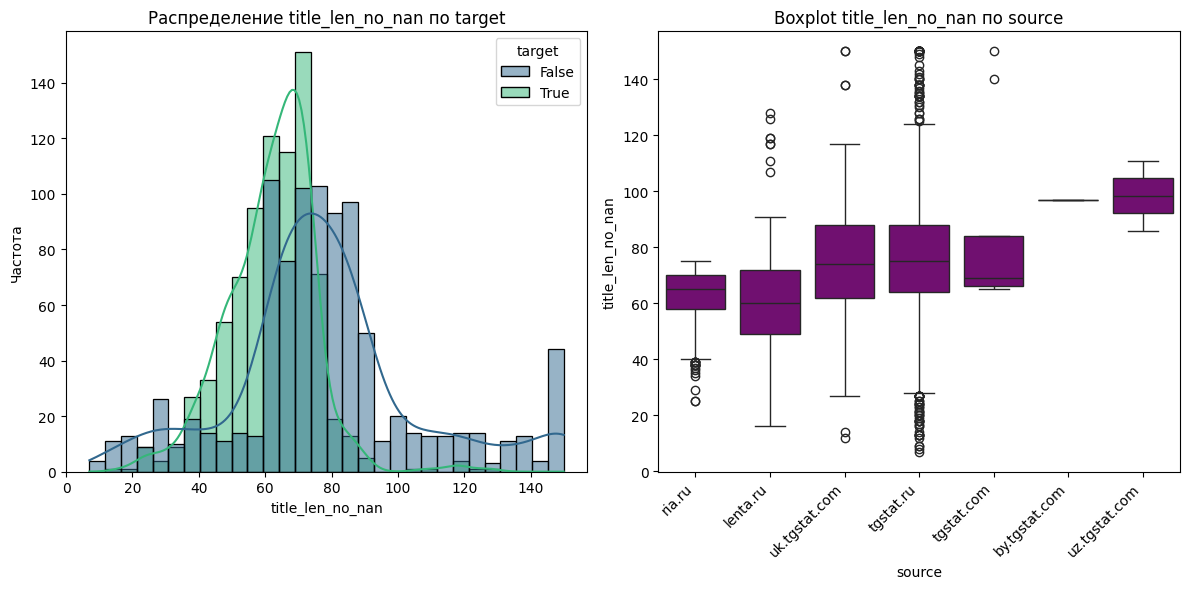

In [23]:
data['title_len_no_nan'] = data.title_cut_ft.apply(get_text_len)
visualize_distribution(data, 'title_len_no_nan', 'source', 'target')

Распределение заголовков улучшись, особенно у фейковых новостей, есть только не большой пик в районе 150, так как мы обрезали по этому числу. С реальными ситуация чуть похуже, распределение немного скошено влево.

**Создание заголовка путем суммаризации основго текста + удаление выбросов**

In [ ]:
tqdm.pandas()

# Формирование заголовков с помощью LLM + обрезка слишком длинных заголовков
def generate_missing_titles(data, summarizer):
    if data.title in ['', 'Без заголовка']:
        summary = summarizer(data.full_text, max_length=50)[0]['summary_text']
        return summary[:150]
    return data.title[:150]

summarizer = pipeline("summarization", model="csebuetnlp/mT5_multilingual_XLSum")
data['title_sum_llm'] = data.progress_apply(generate_missing_titles, args=(summarizer,), axis=1)
torch.cuda.empty_cache()  # После завершения генерации

In [165]:
# Сохраняем
# data.to_csv('data/data_with_llm.csv', index=False)
data = pd.read_csv('data_with_llm.csv')

/home/juliaju_o7/miniconda3/envs/dataml/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


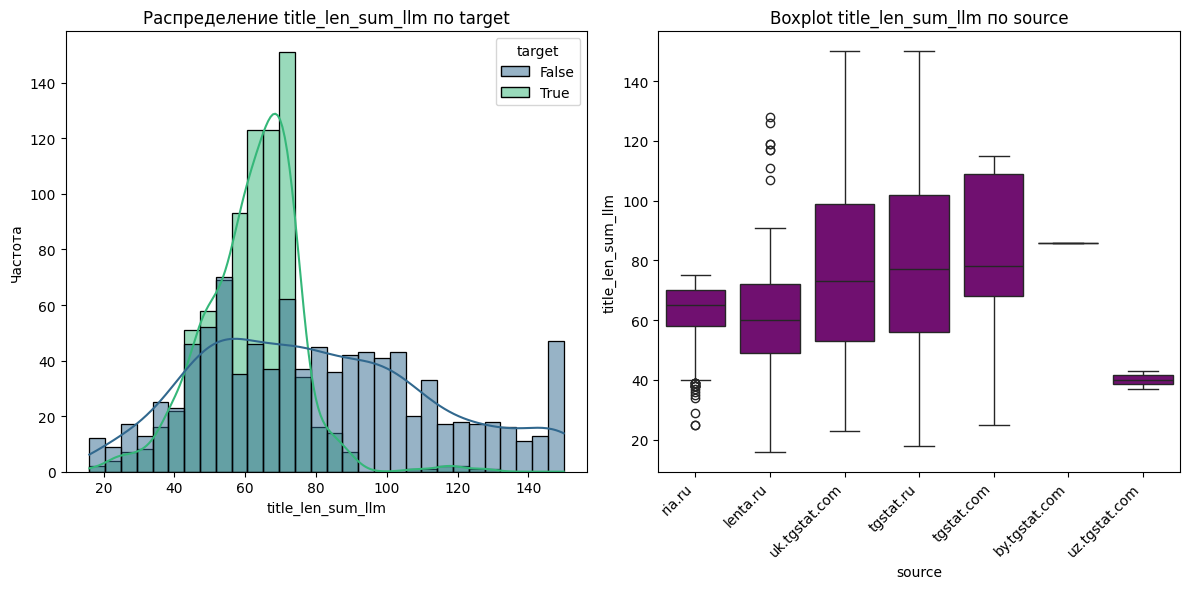

In [167]:
data['title_len_sum_llm'] = data.title_sum_llm.apply(get_text_len)
visualize_distribution(data, 'title_len_sum_llm', 'source', 'target')

In [168]:
data[['title', 'title_sum_llm']].tail()

title  \
1745  Без заголовка   
1746  Без заголовка   
1747  Без заголовка   
1748  Без заголовка   
1749  Без заголовка   

                                                                                                                         title_sum_llm  
1745                            В американском штате Калифорния умерла 13-летняя девочка, которая скрылась с места аварии в 2011 году.  
1746                                         Американская полиция обнародовала историю убийства чернокожей девочки в штате Калифорния.  
1747  История Камала Харрис, сбившей 13-летнюю девочку и скрывшаяся с места аварии в 2011 году, обнародована на официальном сайте США.  
1748                            В американском штате Калифорния умерла 13-летняя девочка, которая скрылась с места аварии в 2011 году.  
1749                                                                             В Германии в воскресенье прошли парламентские выборы.

Распределения по длине заголовков по обеим целевым переменным вышли не самые лучшие, однако выбросов не наблюдается. И с точки зрения читабельности суммаризированные заголовки выглядят лучше.

**Заполнение пропусков в просмотрах**

/home/juliaju_o7/miniconda3/envs/dataml/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


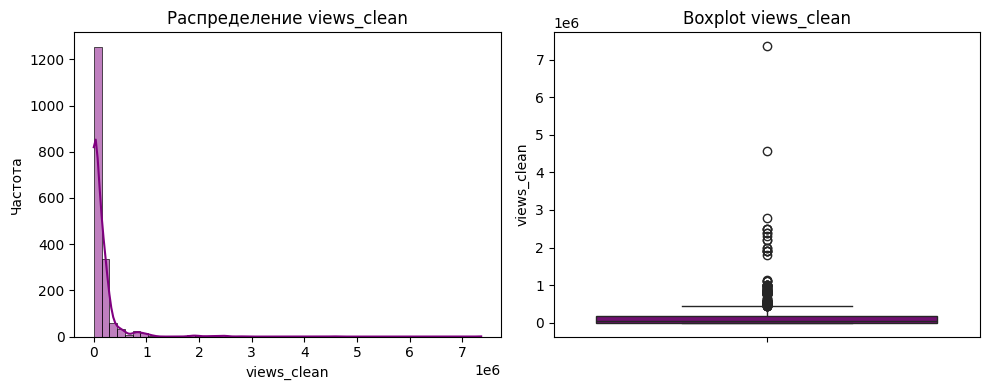


Описательная статистика для столбца 'views_clean':
count    1.750000e+03
mean     1.368747e+05
std      3.327471e+05
min      0.000000e+00
25%      5.030000e+02
50%      4.530000e+04
75%      1.760750e+05
max      7.356376e+06
Name: views_clean, dtype: float64


In [169]:
visualize_views_distribution(data, 'views_clean')

In [170]:
popular_news = data[data.views_clean > 1000000][['title_sum_llm', 'full_text_len', 'views_clean']].index.tolist()
print(f'Количество новостей с просмотром больше 1 млн.: {len(popular_news)}')
data[data.views_clean > 2000000][['title_sum_llm', 'full_text_len', 'views_clean']]

Количество новостей с просмотром больше 1 млн.: 22


title_sum_llm  \
69                                                                                               Что такое ретроградный Меркурий и как он влияет на человека   
321                                                                                               Как отдыхаем в мае 2025 года: праздники и перенос выходных   
330                                                                                 Родительские субботы в 2025 году: расписание и традиции поминальных дней   
865                                                                                                         В очередной подборке интересных новостей недели:   
1111                                                                      Я не хотел ничего писать о том, чтобы ещё раз погиб минимум миллион наших граждан.   
1298  Джонни Депп запускает бизнес в России. Он вложил $500.000 в открытие ювелирного магазина в Москве, где будут представлены элитные украшения с якутским   
1443                                                                                         В соцсетях появилось множество мемов, о которых никто не знает.   
1481                                                                                                   В Японии начали бороться с дискриминацией чернокожих.   
1533                                                                                  Астрономы обнаружили в нашей галактике нечеловеческий внеземный разум.   
1565                                                                 Президент США Дональд Трамп и его соперник Джо Байден впервые встретились в Белом доме.   
1669                                                                     Домашний медведь в Сербии оказался в центре внимания многих пользователей соцсетей.   

      full_text_len  views_clean  
69              287    7356376.0  
321             288    4561565.0  
330             341    2792852.0  
865             356    2200000.0  
1111            932    2200000.0  
1298            295    2300000.0  
1443            234    2500000.0  
1481            278    2400000.0  
1533            441    2500000.0  
1565            212    2500000.0  
1669            285    2400000.0

In [171]:
# Удаление строк с большими просмотрами
data = data.drop(index=popular_news)

**Заполнение медианой**

/home/juliaju_o7/miniconda3/envs/dataml/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


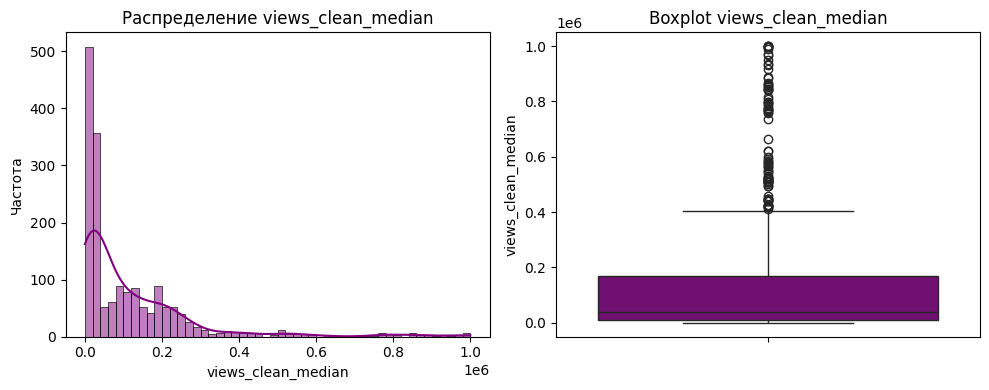


Описательная статистика для столбца 'views_clean_median':
count       1728.000000
mean      115849.293403
std       161755.618215
min            3.000000
25%         8371.750000
50%        39888.000000
75%       168150.000000
max      1000000.000000
Name: views_clean_median, dtype: float64


In [172]:
data['views_clean_median'] = data['views_clean'].replace(0, data['views_clean'].median())
visualize_views_distribution(data, 'views_clean_median')

После заполнения пропусков медианным значением распределение практически не изменилось.

**Заполнение средним значением без выбросов**

/home/juliaju_o7/miniconda3/envs/dataml/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


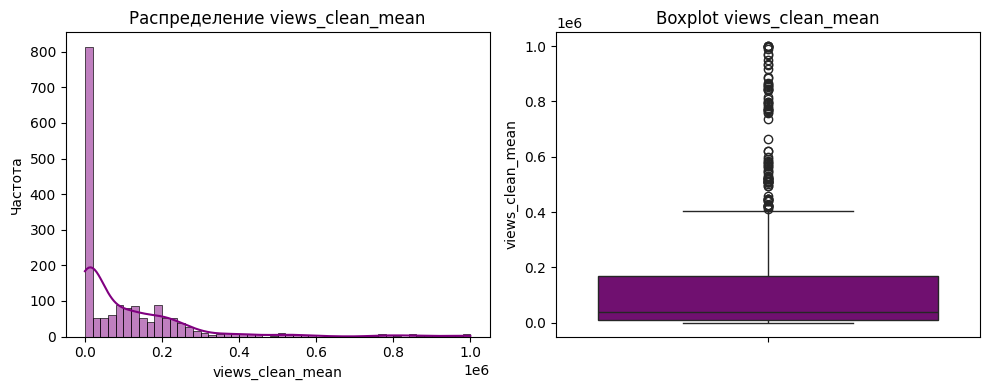


Описательная статистика для столбца 'views_clean_mean':
count       1728.000000
mean      111800.297618
std       163880.748183
min            3.000000
25%         8371.750000
50%        39851.000000
75%       168150.000000
max      1000000.000000
Name: views_clean_mean, dtype: float64


In [173]:
data['views_clean_mean'] = data['views_clean'].replace(0, data[data['views_clean'] < 100000]['views_clean'].mean())
visualize_views_distribution(data, 'views_clean_mean')

После заполнения пропусков средним значением распределение также практически не изменилось.

**Заполнение пропусков в тегах с помощью тематического моделирования**

In [204]:
# Заполнение пустых строк тегов с помощью 'Без тегов'
data['tags'] = data.tags.fillna('Без тегов')

# Выделение тематических слов из текста с помощью LDA
def strict_noun_extractor(data, n_topics=1, n_words=4):
    
    if data.tags == 'Без тегов':
        morph = MorphAnalyzer()
        
        def get_nouns(text):
            words = re.findall(r'[а-яё]+', text.lower())
            nouns = []
            for word in words:
                for parsed in morph.parse(word):
                    if 'NOUN' in parsed.tag:
                        try:
                            nouns.append(parsed.inflect({'nomn'}).word)
                            break
                        except:
                            continue
            return nouns
        
        noun_texts = get_nouns(data.full_text)
        
        # Проверка количества уникальных слов
        vectorizer = CountVectorizer(max_features=500)
        X = vectorizer.fit_transform(noun_texts)
        
        # Проверка перед обучением
        n_topics = min(n_topics, X.shape[0])  # Не больше тем, чем документов
        n_words = min(n_words, X.shape[1])    # Не больше слов, чем в словаре
        
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(X)
        
        feature_names = vectorizer.get_feature_names_out()
        topics = []
        for topic in lda.components_:
            topics.append([str(feature_names[i]) for i in topic.argsort()[:-n_words-1:-1]])
        return topics[0]
    else:
        return data.tags


data['tags_no_nan'] = data.apply(strict_noun_extractor, axis=1)

In [208]:
data.tags_no_nan.tail(15)

1735           [церковь, храм, сатанисты, украина]
1736         [церковь, солнцепёк, прачечная, луцк]
1737      [чат, церковь, церковнослужащие, херсон]
1738                [люди, жизнь, хопкинс, энтони]
1739               [учитель, право, эноха, тюрьма]
1740               [учитель, право, эноха, тюрьма]
1741                 [учитель, право, энох, эноха]
1742    [учитель, эноха, тюрьма, трансгендерность]
1743                    [право, энох, учитель, уж]
1744                [хозяин, утро, среда, спасибо]
1745               [харрис, девочка, посол, место]
1746            [харрис, девочка, камала, история]
1747                [харрис, девочка, мать, посол]
1748                 [харрис, девочка, посол, год]
1749               [чудо, царьград, удар, тумберг]
Name: tags_no_nan, dtype: object

In [219]:
# Конвертирование тегов из строки в список
def convert_tags_list(data):
    if data == str:
        data = data.replace("'", '"')
        return json.loads(data)
    else:
        return data

data['tags_no_nan'] = data.tags_no_nan.apply(convert_tags_list)

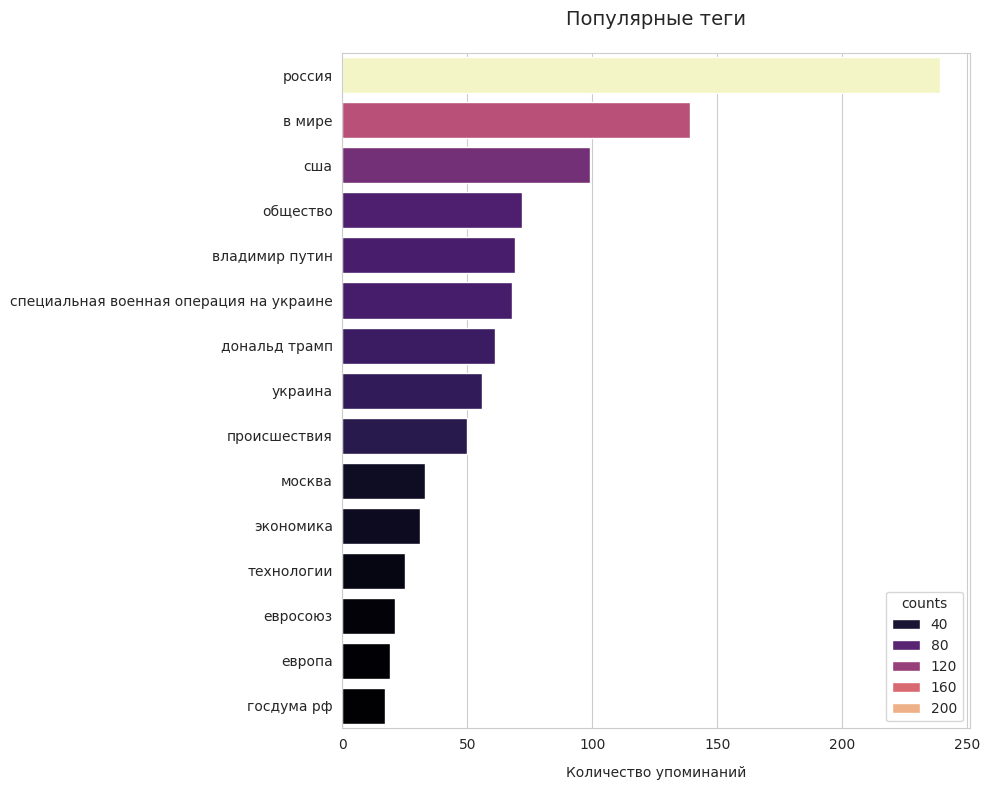

In [262]:
# Подсчет популярных тегов
def get_top_tags(data_series, top_n=10):
    
    # Собираем все теги в один список
    all_tags = []
    for tags_str in data_series:        
        try:
            tags = ast.literal_eval(tags_str)
            tags = [t.lower() for t in tags]
            all_tags.extend(tags)
        except:
            continue
            
    # Считаем частоту тегов
    tag_counts = Counter(all_tags)
    
    # Возвращаем топ-N тегов
    return tag_counts.most_common(top_n)

# Визуализация популярных тегов
def visualize_top_tags(top_tags, title='Топ тегов', top_n=15):
    
    tags = [tag for tag, count in top_tags[:top_n]][::-1]  # Берем top_n и переворачиваем
    counts = [count for tag, count in top_tags[:top_n]][::-1]
    
    df = pd.DataFrame({'tag': tags, 'counts': counts}).sort_values('counts', ascending=False)
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(data=df, y='tag', x='counts', hue='counts', palette="magma")
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Количество упоминаний', labelpad=10)
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

top_tags = get_top_tags(data['tags_no_nan'], top_n=15)
visualize_top_tags(top_tags, title='Популярные теги')

**Сокращение длинных текстов новостей**

In [265]:
data[['full_text', 'full_text_len']].head()

full_text  \
0  ВАШИНГТОН, 2 апр – РИА Новости. Министр обороны США Пит Хегсет не примет участия во встрече международной коалиции по оказанию военной поддержки Украине, которая запланирована на 11 апреля в Брюсселе, сообщает издание Defense News со ссылкой на источники среди американских и европейских должностных лиц.   
1                                                                                                                                                                                            ВАШИНГТОН, 2 апр — РИА Новости. Президент США Дональд Трамп объявил о введении новых пошлин на продукцию других стран.   
2                                                                                                   НИЖНИЙ НОВГОРОД, 2 апр - РИА Новости. Несущие конструкции офисного здания в городе Перевоз Нижегородской области, где произошел взрыв газовоздушной смеси, не повреждены, сообщает региональное управление МЧС.   
3                                                                                                                                                           ВАШИНГТОН, 2 апр - РИА Новости. США вводят пошлины в размере 20% на товары из ЕС, 34% - на товары из Китая, заявил в среду президент США Дональд Трамп.   
4                                                                                                                                                                                             МОСКВА, 2 апр - РИА Новости. Опасность атаки БПЛА объявлена в Краснодарском крае, сообщается в приложении МЧС России.   

   full_text_len  
0            304  
1            118  
2            207  
3            151  
4            117

/home/juliaju_o7/miniconda3/envs/dataml/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


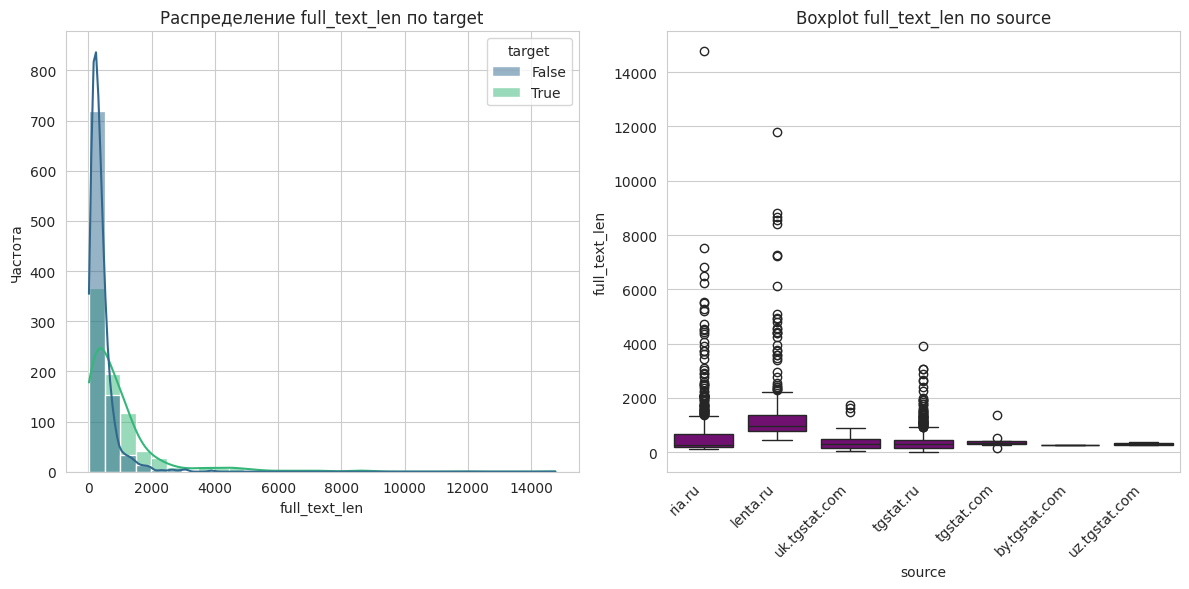

In [266]:
visualize_distribution(data, 'full_text_len', 'source', 'target')

In [267]:
data.full_text_len.describe()

count     1728.000000
mean       667.967593
std       1008.171196
min         20.000000
25%        200.750000
50%        342.000000
75%        772.250000
max      14768.000000
Name: full_text_len, dtype: float64

In [304]:
# Индексы длинных текстов
thresholder = 2000
long_texts_idx = data[(data.full_text_len > thresholder)].index

In [305]:
# Сокращение длинных текстов
def cut_selected_rows(df, text_col, indexes, max_len=100):
    df = df.copy()
    
    for i in indexes:
        if i in df.index:
            text = str(df.loc[i, text_col])
            if len(text) > max_len:
                df.loc[i, text_col] = text[:max_len]
    
    return df


# Обрезаем строки с индексами long_texts_idx
data['cut_text'] = cut_selected_rows(data, 'full_text', long_texts_idx, max_len=thresholder)['full_text']

/home/juliaju_o7/miniconda3/envs/dataml/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


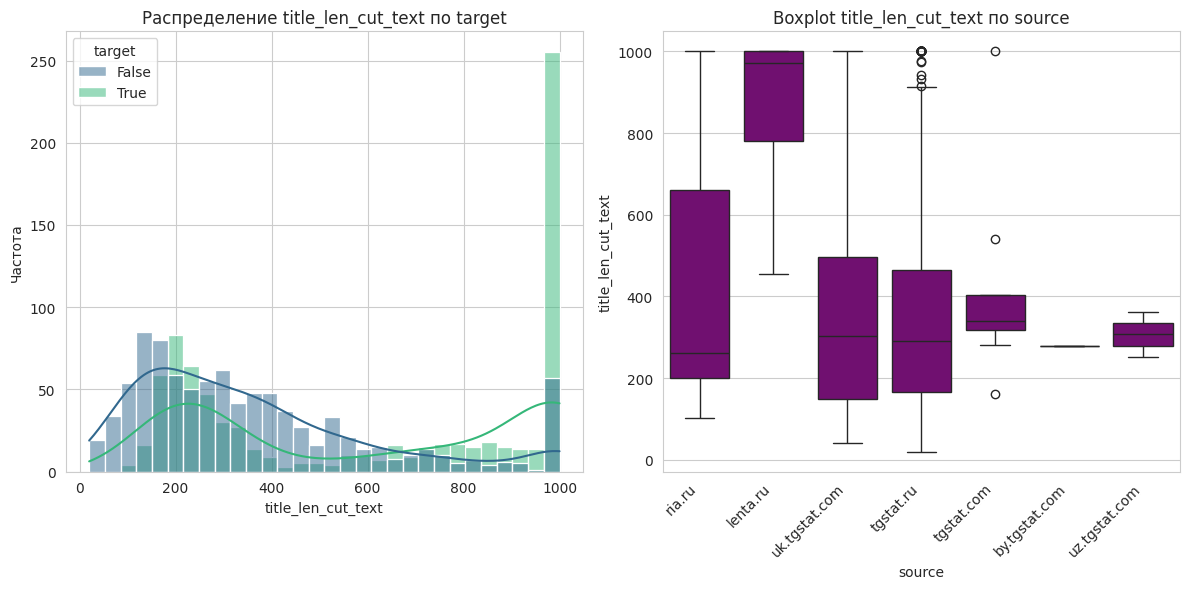

In [306]:
data['title_len_cut_text'] = data.cut_text.apply(get_text_len)
visualize_distribution(data, 'title_len_cut_text', 'source', 'target')

In [307]:
# Удаление строк с выбросами в графе full_text
data = data.drop(index=long_texts_idx)

/home/juliaju_o7/miniconda3/envs/dataml/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


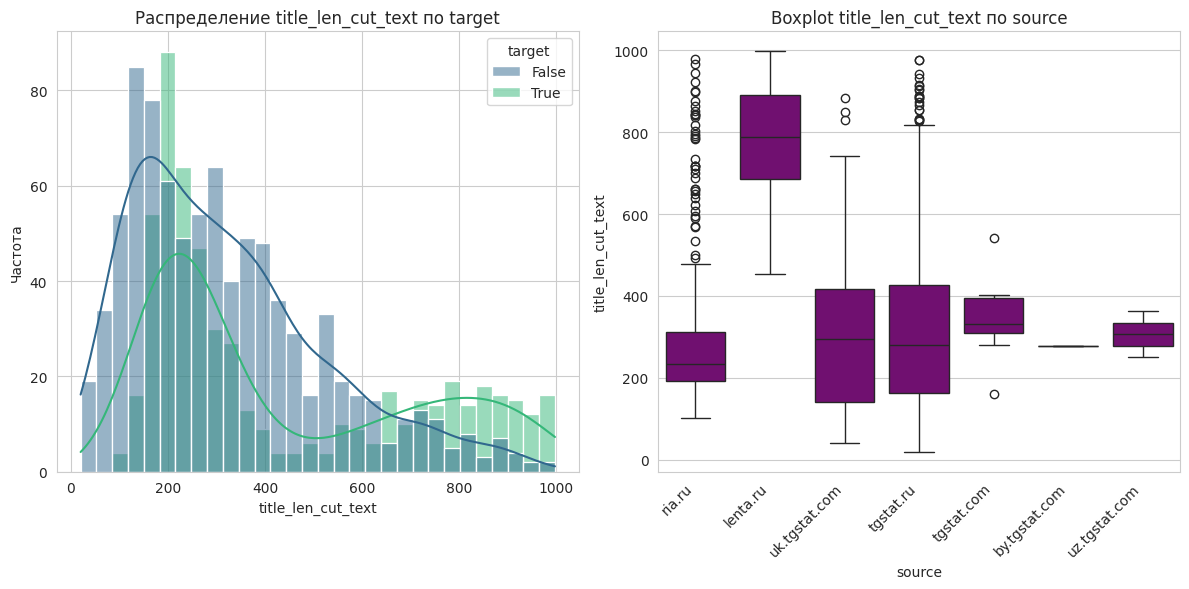

In [308]:
visualize_distribution(data, 'title_len_cut_text', 'source', 'target')

Удаление длинных текстов сделало распределение лучше, без правого пика. Но все равно видно два холмика, что на `Lenta.ru` пишут новости большим объемом.

In [317]:
data_processed = data[['url', 'title_sum_llm', 'cut_text', 'date_published', 'views_clean_median', 'source',
      'title_len_sum_llm', 'title_len_cut_text']]

In [318]:
# Сохраняем итоговый обработанный датасет
data_processed.to_csv('data/data_processed.csv', index=False)

In [319]:
# Анализ данных с помощью библиотеки ydata_profiling
profile = ProfileReport(data_processed, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.87it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Часть 3: «Раскрытие дела»

**Выбор и обоснование самого эффективного метода**

На основании проведенного EDA и экспериментов с различными методами обработки пропусков и выбросов, наиболее эффективным подходом для собранного набора данных будет **комбинированный метод с учетом специфики каждого признака**:

* `url`: Пропусков нет. Этот признак является идентификатором и может быть использован для извлечения дополнительной информации (источник).
* `title`: Значительное количество пропусков (около 29%). Простое удаление строк с пропусками приведет к существенной потере данных. Заполнение строкой `'Без заголовка'` или аналогичным значением сохранит размер датасета, но может внести шум в последующий анализ текста. Оптимальным будет попытаться сгенерировать заголовки из `full_text` для пропущенных значений. 
* `full_text`: Очень мало пропусков (около 0.14%). Их можно удалить, их потеря сильно не повлияет на общий объем данных.
* `date_published`: Крайне мало пропусков (около 0.08%). Также можно удалить.
* `views`: Относительно большое количество пропусков (около 9.40%). Предпочтительным будет вариант заполнения медианой, так как она является более устойчивой к выбросам мерой центральной тенденции.
* `tags`: Значительное количество пропусков (около 29%), часто совпадающих с пропусками в `title`. Оптимальным вариантом будет воспользоваться инструментами тематического моделирования и создать теги на основе основного текста новости.

Выбранный подход учитывает природу каждого признака и количество пропущенных значений. Для признаков с небольшим количеством случайных пропусков удаление является простым и безопасным решением. Для признаков с большим количеством пропусков, где удаление приведет к значительной потере информации предлагаются методы заполнения, которые позволят сохранить полезную информацию или минимизировать влияние пропусков на последующий анализ. Генерация заголовков из текста является более интеллектуальным подходом, чем простое заполнение константой. Медианное заполнение просмотров устойчиво к выбросам.

**Краткая рекомендация по оптимальному подходу к обработке пропущенных значений**

1.  Удалить строки с пропусками в графах `full_text` и `date_published`.
2.  Для пропущенных значений в графе `title` сгенерировать заголовок из `full_text`.
3.  Для пропущенных значений в графе `views` заполнить медианным значением после преобразования в числовой формат.
4.  Для пропущенных значений в графе `tags` сделать тематическое моделирование.
5.  Графа `url` не требует обработки пропусков.

## «Расследование с изюминкой»

**Предложение собственного метода**

Для улучшения обработки пропущенных значений в графе `title`, особенно учитывая его важность для понимания содержания новости, можно предложить следующий **гибридный метод с использованием предварительно обученной языковой модели**:

1.  Применить генерацию заголовков из `full_text`, как описано ранее.
2.  Попробовать обучить модель на имеющихся в датасете парах `(full_text, title)` для улучшения ее способности генерировать релевантные заголовки для конкретно этого набора данных.
3. Сгенерировать несколько вариантов заголовков для каждой статьи с пропущенным `title` и выбрать лучший вариант на основе определенных критериев (например, длина, наличие ключевых слов).

Дообучение модели на датасете позволит ей лучше учитывать специфику новостей в конкретном наборе данных.

**Преимущества:**

* Потенциально более высокое качество сгенерированных заголовков по сравнению с простым заполнением или обрезкой текста.
* Использование информации из `full_text` для восстановления важного признака.

**Недостатки:**

* Требует дополнительных ресурсов для обучения языковой модели.
* Требует выбора и настройки подходящей языковой модели.

В целом всегда при выборе тех или иных подходов, важно учитывать контекст задачи, наличие достаточных ресурсов и необходимость глубокой проработки решения.